In [ ]:
!pip install torch torchvision scikit-image opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PyTorch and Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision

# Other utilities
import numpy as np
import cv2
import random
import time
import os
from torch.autograd import Variable

In [ ]:
# Install and import PyDrive
!pip install -U -q PyDrive2

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os

# Authenticate and create PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the shared zip file using its file ID
file_id = '1eEVo6iMzP4z3MOIEuwrN28ajKa_G6l17'  # Replace with your file ID if needed
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('raindrop_data.zip')  # Save it locally in Colab

# Create extraction path
extract_path = "/content/raindrop_dataset"
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile("raindrop_data.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete at:", extract_path)


✅ Extraction complete at: /content/raindrop_dataset


In [ ]:
# Paths to the ZIPs
train_zip = "/content/raindrop_dataset/train.zip"
test_a_zip = "/content/raindrop_dataset/test_a.zip"
test_b_zip = "/content/raindrop_dataset/test_b.zip"

# Paths to extract them
train_path = "/content/raindrop_dataset/train"
test_a_path = "/content/raindrop_dataset/test_a"
test_b_path = "/content/raindrop_dataset/test_b"

# Extract function
def extract(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted: {zip_path} → {extract_to}")

# Extract all
extract(train_zip, train_path)
extract(test_a_zip, test_a_path)
extract(test_b_zip, test_b_path)

Extracted: /content/raindrop_dataset/train.zip → /content/raindrop_dataset/train
Extracted: /content/raindrop_dataset/test_a.zip → /content/raindrop_dataset/test_a
Extracted: /content/raindrop_dataset/test_b.zip → /content/raindrop_dataset/test_b


In [ ]:
#define path
train_rain_path = "/content/raindrop_dataset/train/train/data"
train_clean_path = "/content/raindrop_dataset/train/train/gt"

test_a_rain_path = "/content/raindrop_dataset/test_a/test_a/data"
test_a_clean_path = "/content/raindrop_dataset/test_a/test_a/gt"

test_b_rain_path = "/content/raindrop_dataset/test_b/test_b/data"
test_b_clean_path = "/content/raindrop_dataset/test_b/test_b/gt"

In [ ]:
#manually clearing gpu memory
import torch
torch.cuda.empty_cache()

In [ ]:
# Add memory config
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Dataset Class
class ImageRestorationDataset(Dataset):
    def __init__(self, input_dir, gt_dir, image_size=(256, 256)):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.input_images = sorted(os.listdir(input_dir))
        self.gt_images = sorted(os.listdir(gt_dir))
        self.image_size = image_size  # (width, height)

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        # Load images
        input_img = cv2.imread(os.path.join(self.input_dir, self.input_images[idx]))
        gt_img = cv2.imread(os.path.join(self.gt_dir, self.gt_images[idx]))

        # Resize to fixed size
        input_img = cv2.resize(input_img, self.image_size)  # Resize to (W, H)
        gt_img = cv2.resize(gt_img, self.image_size)

        # Convert to float32 and normalize to [0,1]
        input_img = input_img.astype('float32') / 255.0
        gt_img = gt_img.astype('float32') / 255.0

        # Convert to tensor and reorder dimensions to C x H x W
        input_img = torch.from_numpy(input_img.transpose((2, 0, 1)))
        gt_img = torch.from_numpy(gt_img.transpose((2, 0, 1)))

        return input_img, gt_img

# Create DataLoader
train_dataset = ImageRestorationDataset(
    input_dir=train_rain_path,
    gt_dir=train_clean_path,
    image_size=(128, 128)  # You can change this to another fixed size if needed
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Import models
# from models import generator as generator_module
# from models import discriminator as discriminator_module

# # Device-agnostic setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Initialize models
# generator = generator_module.Generator().to(device)
# discriminator = discriminator_module.Discriminator().to(device)

# # Loss and Optimizers
# criterion = nn.MSELoss()
# optimizer_g = optim.Adam(generator.parameters(), lr=2e-4)
# optimizer_d = optim.Adam(discriminator.parameters(), lr=2e-4)

# # Training loop
# num_epochs = 5

# for epoch in range(num_epochs):
#     generator.train()
#     discriminator.train()

#     for i, (input_img, gt_img) in enumerate(train_loader):
#         input_img = input_img.to(device)
#         gt_img = gt_img.to(device)

#         # Train Discriminator
#         optimizer_d.zero_grad()


#         mask_list, frame1, frame2, fake_img = generator(input_img)
#         fake_img = fake_img.detach()

#         _, real_pred = discriminator(gt_img)
#         _, fake_pred = discriminator(fake_img)

#         d_loss_real = criterion(real_pred, torch.ones_like(real_pred))
#         d_loss_fake = criterion(fake_pred, torch.zeros_like(fake_pred))
#         d_loss = (d_loss_real + d_loss_fake) * 0.5
#         d_loss.backward()
#         optimizer_d.step()

#         # Train Generator
#         optimizer_g.zero_grad()
#         _, fake_pred = discriminator(fake_img)
#         g_loss_adv = criterion(fake_pred, torch.ones_like(fake_pred))
#         g_loss_l1 = criterion(fake_img, gt_img)
#         g_loss = g_loss_adv + g_loss_l1
#         g_loss.backward()
#         optimizer_g.step()

#         if i % 10 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
#                   f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

#     # Save generator weights after each epoch
#     torch.save(generator.state_dict(), f"gen_epoch_{epoch+1}.pkl")

# # Final save
# torch.save(generator.state_dict(), "gen.pkl")
# print("Saved generator weights as gen.pkl")


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from models import generator as generator_module
from models import discriminator as discriminator_module
from models.vgg_init import vgg_init, vgg

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
generator = generator_module.Generator().to(device)
discriminator = discriminator_module.Discriminator().to(device)

# VGG model for perceptual loss
vgg_model = vgg_init()
vgg_loss_model = vgg(vgg_model).to(device)

# Loss and Optimizers
adv_criterion = nn.MSELoss()
l1_criterion = nn.L1Loss()
optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training parameters
num_epochs = 25
warmup_epochs = 5
adv_weight_schedule = lambda epoch: min(1.0, (epoch - warmup_epochs + 1) / 5) if epoch >= warmup_epochs else 0.0

# Training loop
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    for i, (input_img, gt_img) in enumerate(train_loader):
        input_img = input_img.to(device)
        gt_img = gt_img.to(device)

        # ------------------------
        # Train Discriminator
        # ------------------------
        for _ in range(2):  # Train D twice per iteration
            optimizer_d.zero_grad()

            with torch.no_grad():
                _, _, _, fake_img_d = generator(input_img)

            _, real_pred = discriminator(gt_img)
            _, fake_pred = discriminator(fake_img_d)

            # Label smoothing
            real_labels = torch.empty_like(real_pred).uniform_(0.9, 1.0)
            fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.1)

            d_loss_real = adv_criterion(real_pred, real_labels)
            d_loss_fake = adv_criterion(fake_pred, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) * 0.5
            d_loss.backward()
            optimizer_d.step()

        # ------------------------
        # Train Generator
        # ------------------------
        optimizer_g.zero_grad()

        _, _, _, fake_img = generator(input_img)
        _, fake_pred = discriminator(fake_img)

        # L1 Loss
        g_loss_l1 = l1_criterion(fake_img, gt_img)

        # Perceptual Loss
        gen_feat = vgg_loss_model(fake_img)
        real_feat = vgg_loss_model(gt_img)
        g_loss_percep = sum([F.l1_loss(gf, rf) for gf, rf in zip(gen_feat, real_feat)])

        # Adversarial Loss
        adv_weight = adv_weight_schedule(epoch)
        g_loss_adv = adv_criterion(fake_pred, torch.ones_like(fake_pred))

        # Total Generator Loss
        g_loss = adv_weight * g_loss_adv + 100 * g_loss_l1 + 10 * g_loss_percep
        g_loss.backward()
        optimizer_g.step()

        # Logging
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            print(f"Discriminator Output (Real Mean): {real_pred.mean().item():.4f}, "
                  f"(Fake Mean): {fake_pred.mean().item():.4f}")

    # Save model weights
    os.makedirs('./weights', exist_ok=True)
    torch.save(generator.state_dict(), f'./weights/gen_epoch_{epoch+1}.pkl')
    torch.save(discriminator.state_dict(), f'./weights/disc_epoch_{epoch+1}.pkl')

# Final save
torch.save(generator.state_dict(), "./weights/gen.pkl")
print("Training complete. Generator saved as gen.pkl")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s]


Epoch [1/25], Step [1/216], D Loss: 0.2092, G Loss: 66.2209
Discriminator Output (Real Mean): 0.4804, (Fake Mean): 0.4932
Epoch [1/25], Step [51/216], D Loss: 0.0030, G Loss: 23.5569
Discriminator Output (Real Mean): 0.9901, (Fake Mean): 0.0568
Epoch [1/25], Step [101/216], D Loss: 0.0142, G Loss: 17.5418
Discriminator Output (Real Mean): 0.9346, (Fake Mean): 0.0811
Epoch [1/25], Step [151/216], D Loss: 0.0850, G Loss: 19.9395
Discriminator Output (Real Mean): 0.7215, (Fake Mean): 0.1535
Epoch [1/25], Step [201/216], D Loss: 0.0340, G Loss: 15.7230
Discriminator Output (Real Mean): 0.9793, (Fake Mean): 0.2702
Epoch [2/25], Step [1/216], D Loss: 0.0901, G Loss: 16.6252
Discriminator Output (Real Mean): 0.8056, (Fake Mean): 0.2966
Epoch [2/25], Step [51/216], D Loss: 0.0984, G Loss: 12.7066
Discriminator Output (Real Mean): 0.6807, (Fake Mean): 0.3059
Epoch [2/25], Step [101/216], D Loss: 0.0432, G Loss: 16.2518
Discriminator Output (Real Mean): 0.9801, (Fake Mean): 0.2901
Epoch [2/25], 

In [ ]:
# # Initialize the Generator
# generator = generator_module.Generator().cuda()

# # Load the pre-trained generator weights
# generator.load_state_dict(torch.load('gen.pkl'))

# # Initialize the Discriminator
# discriminator = discriminator_module.Discriminator().cuda()


In [ ]:
# # Loss function
# import os
# criterion = nn.MSELoss()

# # Optimizers for Generator and Discriminator
# optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# # Training Loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     for i, (input_img, gt_img) in enumerate(train_loader):
#         # Move to GPU
#         input_img, gt_img = input_img.cuda(), gt_img.cuda()

#         # Zero gradients
#         optimizer_g.zero_grad()
#         optimizer_d.zero_grad()

#         # Forward pass through Generator
#         _, _, _, gen_output = generator(input_img)

#         # Discriminator predictions
#         _, real_pred = discriminator(gt_img)
#         _, fake_pred = discriminator(gen_output)

#         # Generator loss (only updates generator)
#         g_loss = criterion(fake_pred, torch.ones_like(fake_pred))  # Generator wants fake to be real
#         g_loss.backward()
#         optimizer_g.step()

#         # Now train discriminator separately with detached fake_pred
#         _, fake_pred_detached = discriminator(gen_output.detach())
#         _, real_pred = discriminator(gt_img)

#         # Discriminator loss
#         real_loss = criterion(real_pred, torch.ones_like(real_pred))
#         fake_loss = criterion(fake_pred_detached, torch.zeros_like(fake_pred_detached))
#         d_loss = (real_loss + fake_loss) / 2

#         # Backprop and optimize Discriminator
#         d_loss.backward()
#         optimizer_d.step()


#         # Print losses for monitoring
#         if i % 5 == 0:
#             print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
#                   f"Loss G: {g_loss.item():.4f}, Loss D: {d_loss.item():.4f}")



#     # Create directory if it doesn't exist
#     os.makedirs('./weights', exist_ok=True)

#     # Save model weights after every epoch
#     torch.save(generator.state_dict(), f'./weights/gen_epoch_{epoch}.pkl')
#     torch.save(discriminator.state_dict(), f'./weights/disc_epoch_{epoch}.pkl')


In [ ]:
# def evaluate_model(test_loader):
#     cumulative_psnr = 0
#     cumulative_ssim = 0
#     for i, (input_img, gt_img) in enumerate(test_loader):
#         input_img, gt_img = input_img.cuda(), gt_img.cuda()

#         with torch.no_grad():
#             gen_output = generator(input_img)

#         # Convert output to numpy arrays and compute metrics
#         gen_output = gen_output.cpu().numpy().transpose((0, 2, 3, 1)) * 255.0
#         gt_img = gt_img.cpu().numpy().transpose((0, 2, 3, 1)) * 255.0

#         for j in range(input_img.size(0)):
#             cur_psnr = calc_psnr(gen_output[j], gt_img[j])
#             cur_ssim = calc_ssim(gen_output[j], gt_img[j])
#             cumulative_psnr += cur_psnr
#             cumulative_ssim += cur_ssim

#     avg_psnr = cumulative_psnr / len(test_loader)
#     avg_ssim = cumulative_ssim / len(test_loader)
#     print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")

# # Test Dataset
# test_dataset = ImageRestorationDataset(input_dir='/path/to/test_input/', gt_dir='/path/to/test_gt/')
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Evaluate the model on test data
# evaluate_model(test_loader)


In [ ]:
from google.colab import drive
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define input and output directories
#input_dir = '/content/drive/MyDrive/input/'  # <-- change this to your actual folder path
output_dir = '/content/output/'
os.makedirs(output_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Processing image: case1.jpg


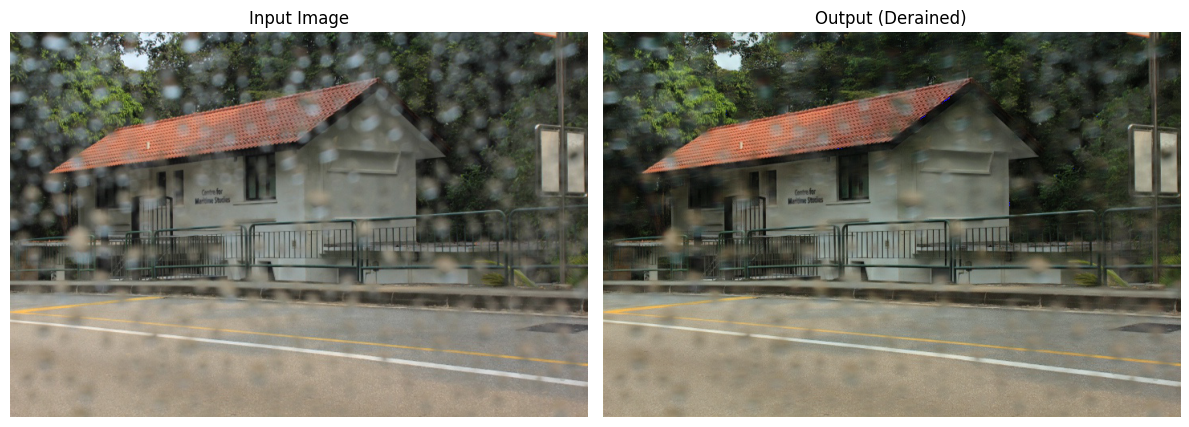

Processing image: case2.jpg


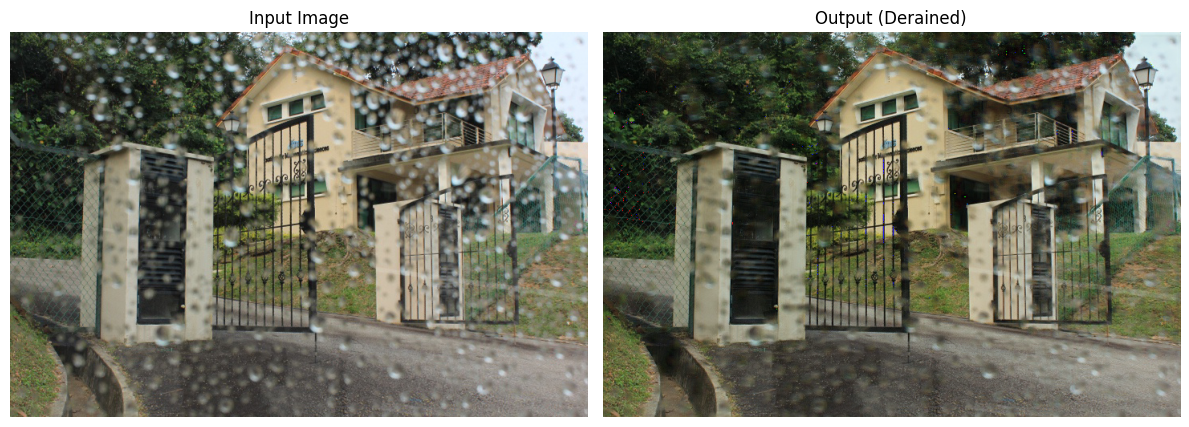

Processing image: case3.jpg


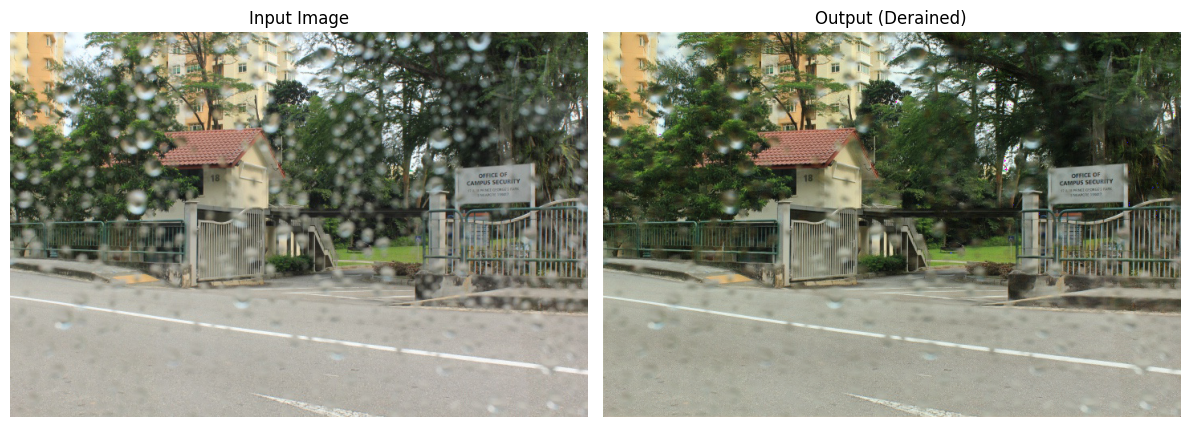

Processing image: case4.jpg


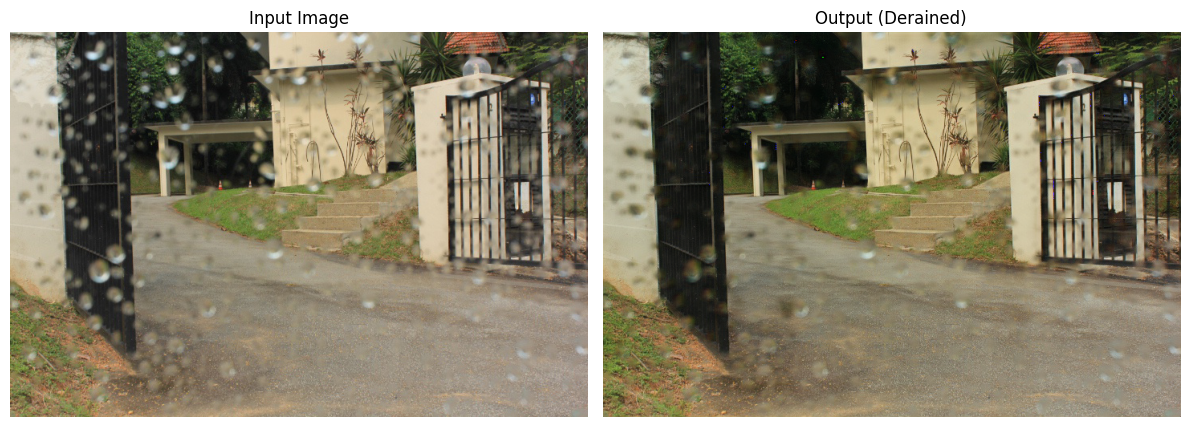

Processing image: case5.jpg


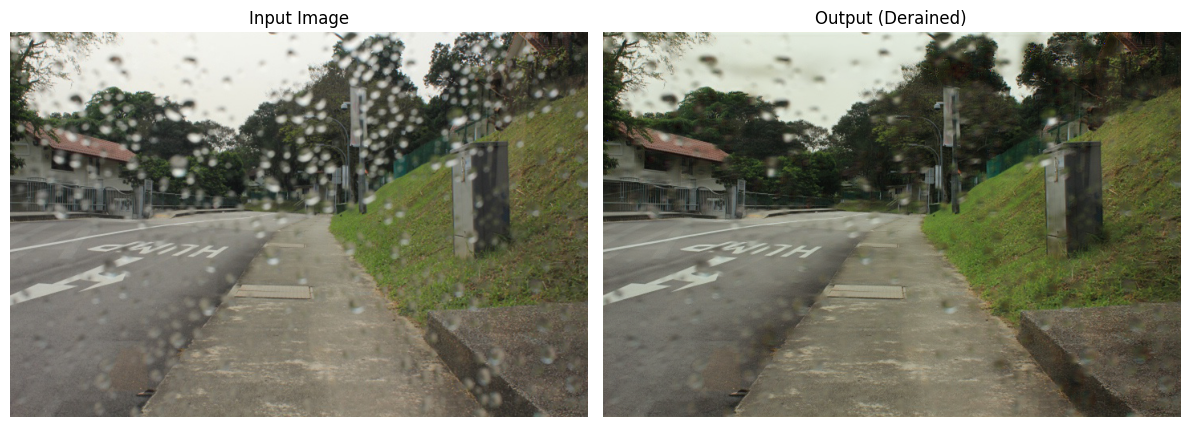

In [ ]:
# PyTorch libs
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

# Tools
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Models
from models import generator as generator_module


def align_to_four(img):
    h, w = img.shape[:2]
    h_aligned = h - h % 4
    w_aligned = w - w % 4
    return img[:h_aligned, :w_aligned]


def predict(image, model):
    image = np.array(image, dtype='float32') / 255.
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :, :, :]
    image = torch.from_numpy(image).cuda()

    with torch.no_grad():
        output = model(image)[-1]

    output = output.cpu().numpy()
    output = output.transpose((0, 2, 3, 1))[0] * 255.
    return output.astype('uint8')


if __name__ == '__main__':
    # Settings
    input_dir = '/content/drive/MyDrive/input/'
    output_dir = './output/'

    # Load model
    model = generator_module.Generator().cuda()
    model.load_state_dict(torch.load('./weights/gen.pkl'))
    model.eval()

    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process images
    input_list = sorted(os.listdir(input_dir))
    for file_name in input_list:
        print(f"Processing image: {file_name}")
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        img = cv2.imread(input_path)
        img = align_to_four(img)

        result = predict(img, model)

        # Save output
        cv2.imwrite(output_path, result)

        # Display side-by-side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("Output (Derained)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import os
import cv2
import numpy as np
import torch
from models import generator as generator_module
import matplotlib.pyplot as plt

def align_to_four(img):
    h, w = img.shape[:2]
    h_aligned = h - h % 4
    w_aligned = w - w % 4
    return img[:h_aligned, :w_aligned]

def predict(image, model):
    image = np.array(image, dtype='float32') / 255.
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :, :, :]
    image = torch.from_numpy(image).cuda()

    with torch.no_grad():
        output = model(image)[-1]

    output = output.cpu().numpy()
    output = output.transpose((0, 2, 3, 1))[0] * 255.
    return output.astype('uint8')

def calculate_psnr(pred, gt):
    return compare_psnr(gt, pred, data_range=255)

def calculate_ssim(pred, gt):
    return compare_ssim(gt, pred, channel_axis=-1, data_range=255)

if __name__ == '__main__':
    # Updated paths
    input_dir = '/content/raindrop_dataset/test_a/test_a/data/'
    gt_dir = '/content/raindrop_dataset/test_a/test_a/gt/'
    output_dir = './output/'

    # Load model
    model = generator_module.Generator().cuda()
    model.load_state_dict(torch.load('./weights/gen.pkl'))
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    input_list = sorted(os.listdir(input_dir))
    gt_list = sorted(os.listdir(gt_dir))  # Make sure GT list is sorted
    total_psnr = 0
    total_ssim = 0
    processed_images = 0

    # Ensure both input and GT lists have the same length
    assert len(input_list) == len(gt_list), "The number of input and GT images do not match."

    for i, file_name in enumerate(input_list):
        print(f"\nProcessing image: {file_name}")

        input_path = os.path.join(input_dir, file_name)
        gt_path = os.path.join(gt_dir, gt_list[i])  # Get corresponding GT image by index
        output_path = os.path.join(output_dir, file_name)

        img = cv2.imread(input_path)
        gt_img = cv2.imread(gt_path)

        # Validate images
        if img is None:
            print(f"❌ Failed to load input image: {input_path}")
            continue
        if gt_img is None:
            print(f"❌ Failed to load GT image: {gt_path}")
            continue

        img = align_to_four(img)
        gt_img = align_to_four(gt_img)

        result = predict(img, model)

        # Save output
        cv2.imwrite(output_path, result)

        # Calculate PSNR & SSIM
        psnr = calculate_psnr(result, gt_img)
        ssim = calculate_ssim(result, gt_img)
        print(f"✅ PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f} for {file_name}")

        total_psnr += psnr
        total_ssim += ssim
        processed_images += 1

    if processed_images > 0:
        avg_psnr = total_psnr / processed_images
        avg_ssim = total_ssim / processed_images
        print(f"\n📊 Average PSNR: {avg_psnr:.2f} dB")
        print(f"📊 Average SSIM: {avg_ssim:.4f}")
    else:
        print("⚠️ No valid images processed. Please check your input/GT directories.")



Processing image: 0_rain.png
✅ PSNR: 20.77 dB | SSIM: 0.8755 for 0_rain.png

Processing image: 10_rain.png
✅ PSNR: 22.57 dB | SSIM: 0.8861 for 10_rain.png

Processing image: 11_rain.png
✅ PSNR: 22.01 dB | SSIM: 0.8561 for 11_rain.png

Processing image: 12_rain.png
✅ PSNR: 21.82 dB | SSIM: 0.7778 for 12_rain.png

Processing image: 13_rain.png
✅ PSNR: 22.31 dB | SSIM: 0.8580 for 13_rain.png

Processing image: 14_rain.png
✅ PSNR: 20.67 dB | SSIM: 0.8178 for 14_rain.png

Processing image: 15_rain.png
✅ PSNR: 21.56 dB | SSIM: 0.7722 for 15_rain.png

Processing image: 16_rain.png
✅ PSNR: 23.65 dB | SSIM: 0.7563 for 16_rain.png

Processing image: 17_rain.png
✅ PSNR: 21.11 dB | SSIM: 0.8267 for 17_rain.png

Processing image: 18_rain.png
✅ PSNR: 21.28 dB | SSIM: 0.7164 for 18_rain.png

Processing image: 19_rain.png
✅ PSNR: 21.74 dB | SSIM: 0.7916 for 19_rain.png

Processing image: 1_rain.png
✅ PSNR: 22.34 dB | SSIM: 0.8150 for 1_rain.png

Processing image: 20_rain.png
✅ PSNR: 21.00 dB | SSIM: 